<a href="https://colab.research.google.com/github/Kotya2001/X-rayLungsSegmentation/blob/main/FinalUnet1channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from keras import backend as K
import gc
from tensorflow.keras import layers
from imutils import paths
from tensorflow.python.keras.models import Sequential
from keras.integration_test.preprocessing_test_utils import preprocessing

In [ ]:
!pip install segmentation-models

In [ ]:
import segmentation_models as sm

In [ ]:
%cd /content/drive/MyDrive/Segmentation

/content/drive/MyDrive/Segmentation


In [ ]:
size = (256, 256)
def image_resize(img, size=(256, 256)):
    return cv2.resize(img,size )

In [ ]:
image_path = os.path.join('../Segmentation/CXR_png')
mask_path = os.path.join('../Segmentation/masks')

In [ ]:
path_mask = list(paths.list_images("/content/drive/MyDrive/Segmentation/masks"))
path_image = list(paths.list_images("/content/drive/MyDrive/Segmentation/CXR_png"))

In [ ]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [ ]:
X = np.array([np.array(np.stack((image_resize(cv2.imread(os.path.join(image_path,filename.split("_mask")[0]+".png"),  0)),), 
                                axis=-1)) 
for filename in image_file_name])

In [ ]:
y = np.array([np.array(np.stack(( cv2.resize(cv2.imread(filename, 0), (256, 256)),), axis=-1)) for filename in path_mask])

In [ ]:
X_flip = np.flip(X , axis = 2)
y_flip = np.flip(y, axis = 2)

X = np.append(X, X_flip, axis = 0)
y = np.append(y, y_flip, axis = 0)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, shuffle=True,
                                                      random_state=42)

In [ ]:
X_train, X_valid = X_train / 255, X_valid / 255

y_train = (y_train/255. > 0.5).astype(float)
y_valid = (y_valid/255. > 0.5).astype(float)

In [ ]:
def loss(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f * y_pred_f)
  union = (K.sum(y_true_f) + K.sum(y_pred_f)) - intersection 

  jaccard_loss = 1 - (intersection / (union + 1e-8))
  # dice_loss = 1 - (2. * intersection) / (K.sum(y_pred_f) + K.sum(y_true_f) + 1e-8)
  bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f)
  # focal_bce = tf.keras.losses.BinaryFocalCrossentropy(gamma=3, from_logits=True)

  loss = jaccard_loss + bce
  return loss

In [ ]:
def iou(y_true, y_pred, smooth=1e-8):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f * y_pred_f)

  # dice = (intersection * 2.) / (K.sum(y_pred_f + y_true_f) + smooth)
  iou = (intersection) / (K.sum(y_pred_f + y_true_f) - intersection + smooth)

  return iou


def f1(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return 2 * (K.sum(y_true * y_pred)+ K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())


In [ ]:
metrics = [iou, f1]

In [ ]:
inputs = layers.Input(shape=(256, 256, 1))

c0 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), padding='same', name = 'C0')(inputs)
Drop = layers.Dropout(0.1)(c0)
c1 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), padding='same', name = 'C1')(Drop)  
c2 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_1')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C3')(c2)
Drop = layers.Dropout(0.1)(c3)
c4 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C4')(Drop) 
c5 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_2')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C6')(c5)
Drop = layers.Dropout(0.2)(c6)
c7 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C7')(Drop)  
c8 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_3')(c7) 

c9 = layers.Conv2D(512, activation='relu', kernel_size=(3,3),padding='same',  name = 'C9')(c8)
Drop = layers.Dropout(0.2)(c9)
c10 = layers.Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', name = 'C10')(Drop)  
c11 = layers.MaxPool2D(pool_size=(2, 2), name = 'MaxPool_4')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=(3,3), padding='same', name = 'C12')(c11)
Drop = layers.Dropout(0.3)(c12)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=(3,3), padding='same', name = 'C13')(Drop)


t01 = layers.Conv2DTranspose(512, kernel_size=(2,2), strides=(2,2), padding='same', name = 'Transpose_T01')(c13)
concat01 = layers.concatenate([t01, c10], axis=3, name= 'Concat_1')

c14 = layers.Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', name = 'C14')(concat01)
Drop = layers.Dropout(0.3)(c14)
c15 = layers.Conv2D(512, activation='relu', kernel_size=(3,3), padding='same', name = 'C15')(Drop)

t02 = layers.Conv2DTranspose(256, kernel_size=(2,2), strides=(2,2), padding='same', name = 'Transpose_T02')(c15)
concat02 = layers.concatenate([t02, c7], axis=3, name= 'Concat_2')

c16 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C16')(concat02)
Drop = layers.Dropout(0.2)(c16)
c17 = layers.Conv2D(256, activation='relu', kernel_size=(3,3), padding='same', name = 'C17')(Drop)

t03 = layers.Conv2DTranspose(128, kernel_size=(2,2), strides=(2, 2), name = 'Transpose_T03')(c17)
concat03 = layers.concatenate([t03, c4], axis=3, name= 'Concat_3')

c18 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C18')(concat03)
Drop = layers.Dropout(0.2)(c18)
c19 = layers.Conv2D(128, activation='relu', kernel_size=(3,3), padding='same', name = 'C19')(Drop)

t04 = layers.Conv2DTranspose(64, kernel_size=(2,2), strides=(2, 2), padding='same', name = 'Transpose_T04')(c19)
concat04 = layers.concatenate([t04, c1], axis=3, name= 'Concat_4')

c20 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), name = 'C20', padding = 'same')(concat04)
Drop = layers.Dropout(0.1)(c20)
c21 = layers.Conv2D(64, activation='relu', kernel_size=(3,3), name = 'C21', padding = 'same')(Drop)

output = layers.Conv2D(1, activation='sigmoid', kernel_size=(1,1), name = 'O/P')(c21)

In [ ]:
initial_learning_rate = 0.0003
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=12,
    decay_rate=0.96,
    staircase=True)

model = keras.Model(inputs, output, name='UNet_L')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=loss,
              metrics=metrics)

In [ ]:
gc.collect()

7978

In [ ]:
callbacks = tf.keras.callbacks.ModelCheckpoint(
        '../Segmentation/UsingFocalLossFOrbest',
        save_best_only=True,
        verbose=1
    )


In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
          batch_size=16, callbacks=callbacks)

Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 0.5616 - iou: 0.6945 - f1: 0.8042
Epoch 00001: val_loss improved from inf to 0.31429, saving model to ../Segmentation/FinalUnet1channel
INFO:tensorflow:Assets written to: ../Segmentation/FinalUnet1channel/assets
84/84 [==============================] - 40s 454ms/step - loss: 0.5616 - iou: 0.6945 - f1: 0.8042 - val_loss: 0.3143 - val_iou: 0.7965 - val_f1: 0.8866
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.2400 - iou: 0.8563 - f1: 0.9225
Epoch 00002: val_loss improved from 0.31429 to 0.27614, saving model to ../Segmentation/FinalUnet1channel
INFO:tensorflow:Assets written to: ../Segmentation/FinalUnet1channel/assets
84/84 [==============================] - 38s 457ms/step - loss: 0.2400 - iou: 0.8563 - f1: 0.9225 - val_loss: 0.2761 - val_iou: 0.8250 - val_f1: 0.9039
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.2040 - iou: 0.8778 - f1: 0.9349
Epoch 00003: val_loss impro

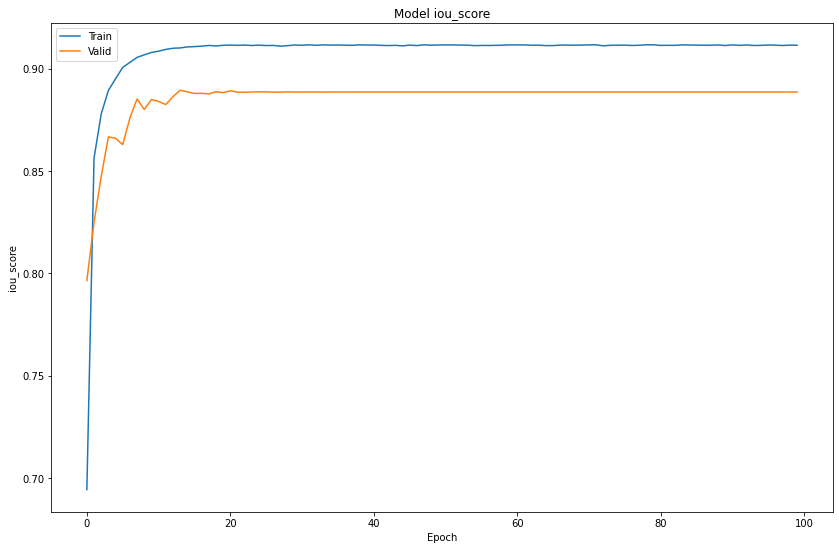

In [ ]:
fig1 = plt.figure(figsize=(14, 9))
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

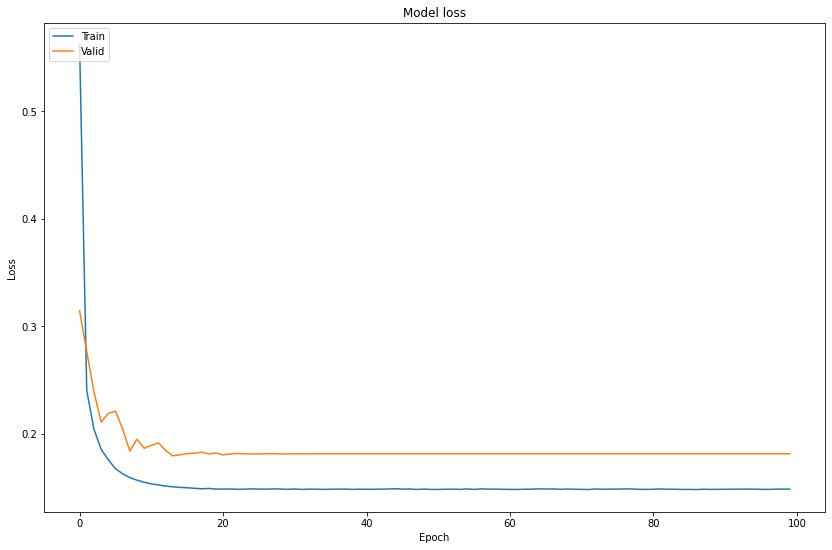

In [ ]:
fig2 = plt.figure(figsize=(14, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

Testing model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model('../Segmentation/FinalUnet1channel', custom_objects={
    'loss' : loss,
    'iou' : metrics[0],
    'f1' : metrics[1]
})

In [ ]:
test_paths = [i for i in os.listdir('/content/drive/MyDrive/Segmentation/test')]

In [ ]:
dir = ['/content/drive/MyDrive/Segmentation/test/' + i for i in test_paths]

In [ ]:
def get_segmentation(model, dir, number):
  image = np.array(np.stack((cv2.resize(cv2.imread(dir[number], 0),
                                              (256, 256)),), axis=-1))
  image = np.expand_dims(image, axis=0)

  image = image / 255.

  prediction = model.predict(image)

  return prediction[0, ..., 0]

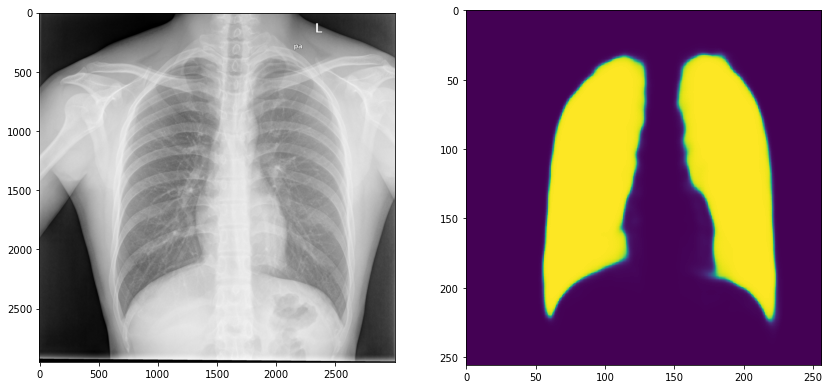

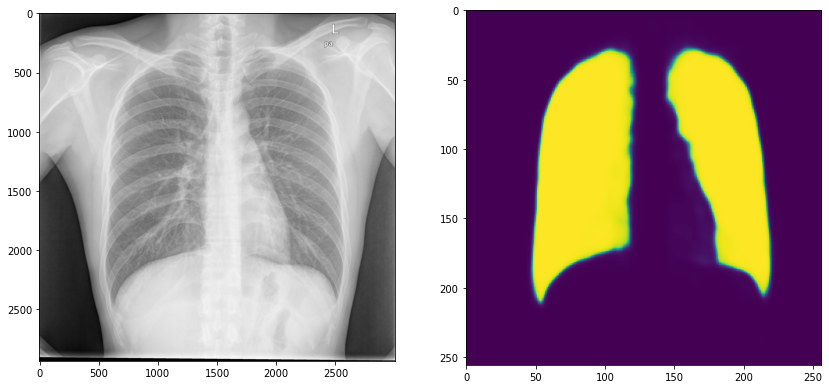

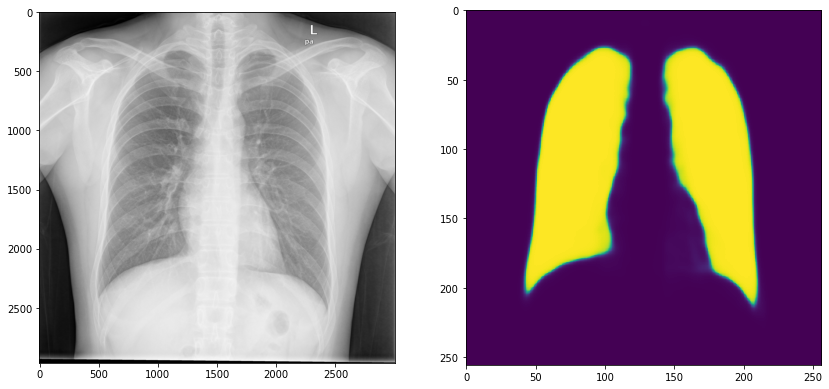

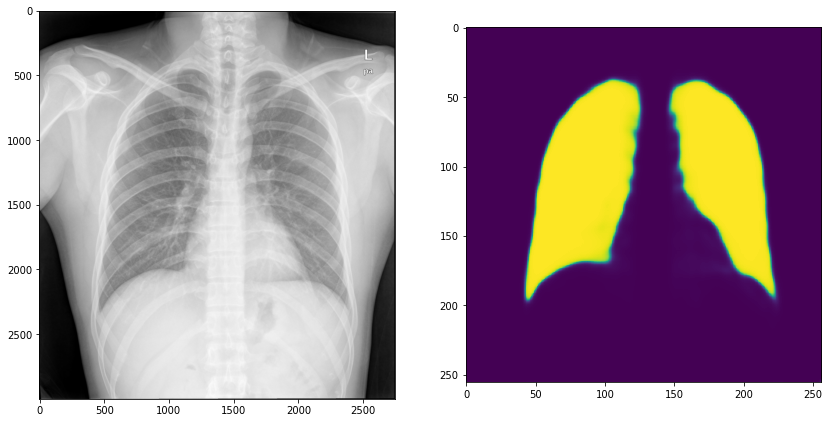

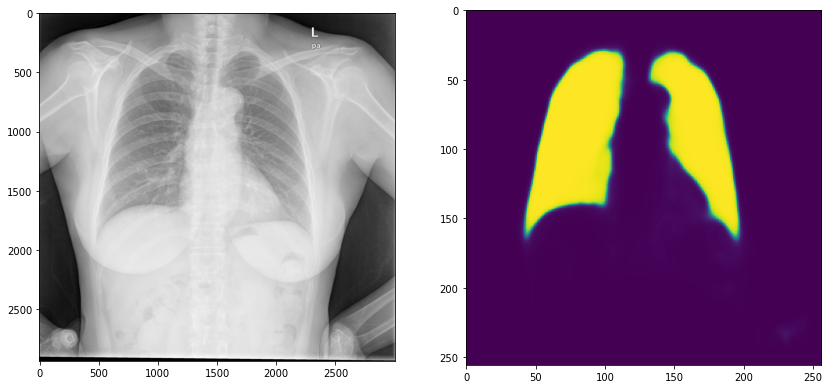

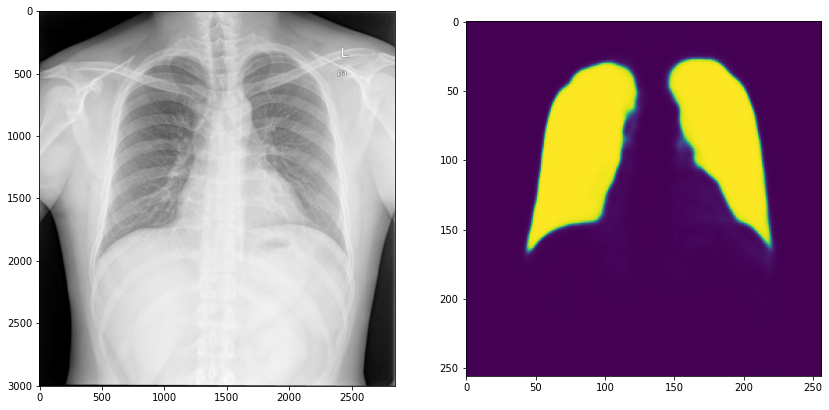

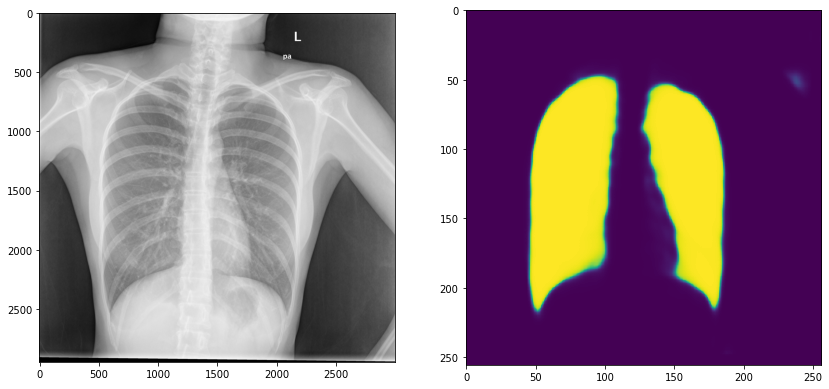

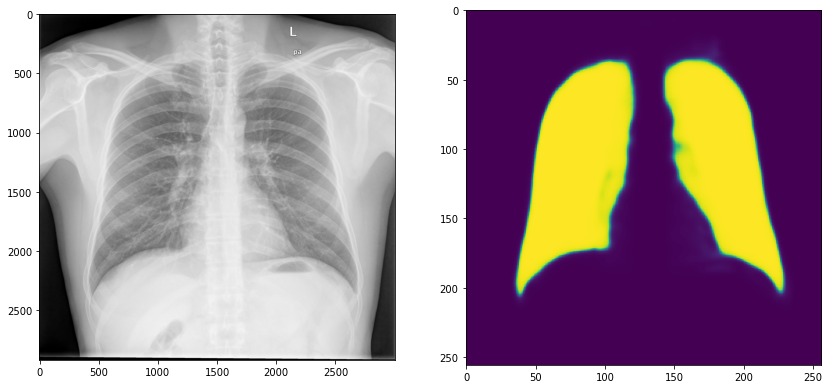

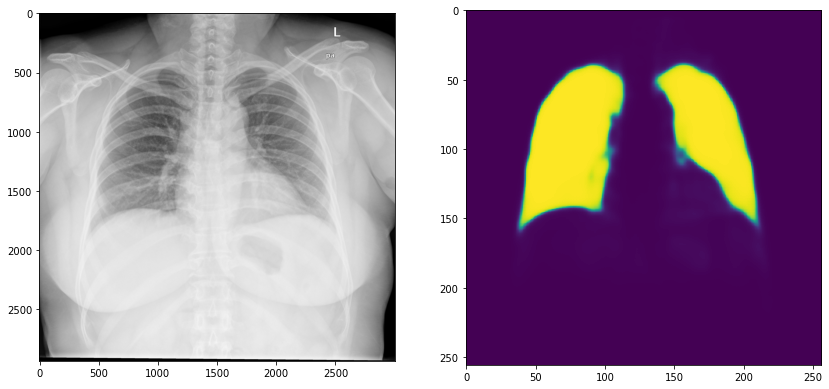

In [ ]:
for i in range(len(dir)):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))
  ax[0].imshow(cv2.imread(dir[i]))
  ax[1].imshow(get_segmentation(loaded_model, dir, i))

  if i > 7:
    break